使用设备: cuda
CLIP模型已加载。
ClipCVAE模型已加载并转换为 float32。
TextToImageEmbedder模型已加载并转换为 float32。


/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pyl

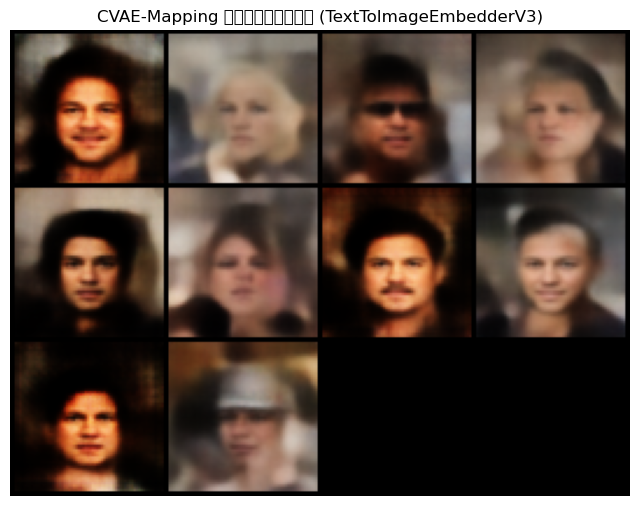

平均余弦相似度 (V3): 0.7520
Mapped Image Embeddings Tensor Shape: torch.Size([10, 512])
Actual Image Embeddings Tensor Shape: torch.Size([10, 512])


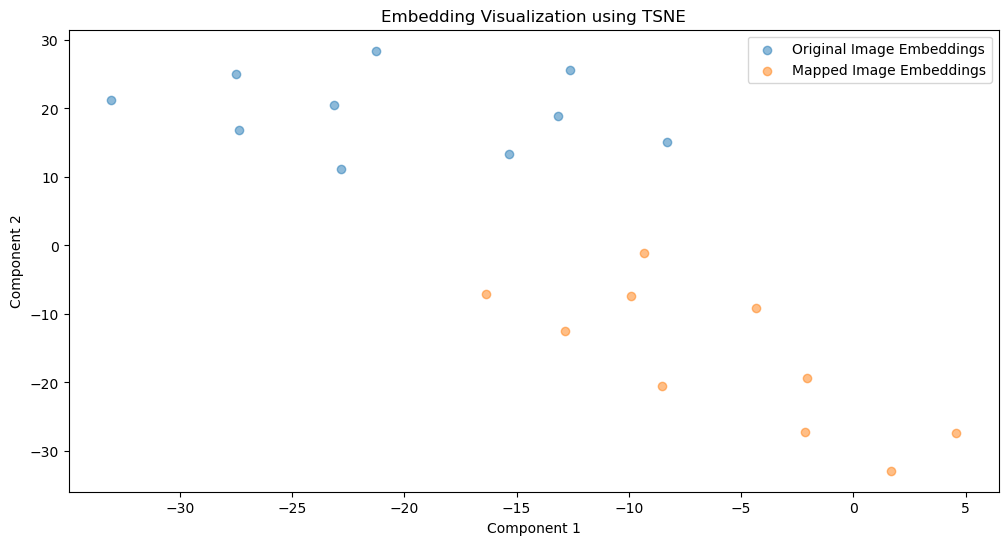

In [1]:
import os
import torch
import torch.nn as nn
import clip
from torchvision import transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

# ------------------------ #
# 1. 设备设置d
# ------------------------ #

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# ------------------------ #
# 2. 加载CLIP模型
# ------------------------ #

clip_model, preprocess_clip = clip.load("ViT-B/32", device=device)
clip_model.eval()
print("CLIP模型已加载。")

# ------------------------ #
# 3. 定义ClipCVAE模型
# ------------------------ #

class ClipCVAE(nn.Module):
    def __init__(self, img_channels=3, img_size=64, latent_dim=128,
                 cond_dim=40, clip_dim=512):
        super(ClipCVAE, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.clip_dim = clip_dim

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels + cond_dim + clip_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(512*4*4, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, latent_dim)

        # 解码器
        self.decoder_input = nn.Linear(latent_dim + cond_dim + clip_dim, 512*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, c, clip_embedding):
        c = c.view(c.size(0), self.cond_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        clip_embedding = clip_embedding.view(clip_embedding.size(0), self.clip_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        x = torch.cat([x, c, clip_embedding], dim=1)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, clip_embedding):
        z = torch.cat([z, c, clip_embedding], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 512, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, c, clip_embedding):
        mu, logvar = self.encode(x, c, clip_embedding)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c, clip_embedding)
        return recon_x, mu, logvar

latent_dim = 128
cond_dim = 40
clip_dim = 512
cvae = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim,
               cond_dim=cond_dim, clip_dim=clip_dim).to(device)
cvae.load_state_dict(torch.load('clip_cvae_celeba.pth', map_location=device))
cvae = cvae.float()
cvae.eval()
print("ClipCVAE模型已加载并转换为 float32。")

# ------------------------ #
# 4. 定义TextToImageEmbedder模型 (V2 版本)
# ------------------------ #
# 请确保此结构与您训练text_to_image_embedder_v3.pth时使用的结构一致
# 定义优化后的映射网络模型 V2 (增加深度和宽度)
class TextToImageEmbedderV2(nn.Module): # V2 表示 Version 2
    def __init__(self, clip_dim=512, embed_dim=512):
        super(TextToImageEmbedderV2, self).__init__()
        self.mapping = nn.Sequential(
            nn.Linear(clip_dim, 4096), # 加宽到 4096
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(4096, 2048), # 加宽到 2048
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512), # 增加一个 512 维度的隐藏层
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, embed_dim) # 输出层保持不变
        )

    def forward(self, text_embeddings):
        image_embeddings = self.mapping(text_embeddings)
        return image_embeddings

embedder = TextToImageEmbedderV2(clip_dim=512, embed_dim=512).to(device) # 使用 TextToImageEmbedderV2 here!
embedder.load_state_dict(torch.load('text_to_image_embedder_v3.pth', map_location=device), strict=True) # 加载 v3 权重
embedder = embedder.float()
embedder.eval()
print("TextToImageEmbedder模型已加载并转换为 float32。")

# ------------------------ #
# 5. 定义属性标签映射函数 (与之前代码相同)
# ------------------------ #

def get_attributes_from_prompt(prompt):
    attrs = torch.zeros(40).float()
    attr_dict = {
        '5_o_Clock_Shadow': 1,
        'Arched_Eyebrows': 2,
        'Attractive': 3,
        'Bags_Under_Eyes': 4,
        'Bald': 5,
        'Bangs': 6,
        'Big_Lips': 7,
        'Big_Nose': 8,
        'Black_Hair': 9,
        'Blond_Hair': 10,
        'Blurry': 11,
        'Brown_Hair': 12,
        'Bushy_Eyebrows': 13,
        'Chubby': 14,
        'Double_Chin': 15,
        'Eyeglasses': 16,
        'Goatee': 17,
        'Gray_Hair': 18,
        'Heavy_Makeup': 19,
        'High_Cheekbones': 20,
        'Male': 21,
        'Mouth_Slightly_Open': 22,
        'Mustache': 23,
        'Narrow_Eyes': 24,
        'No_Beard': 25,
        'Oval_Face': 26,
        'Pale_Skin': 27,
        'Pointy_Nose': 28,
        'Receding_Hairline': 29,
        'Rosy_Cheeks': 30,
        'Sideburns': 31,
        'Smiling': 32,
        'Straight_Hair': 33,
        'Wavy_Hair': 34,
        'Wearing_Earrings': 35,
        'Wearing_Hat': 36,
        'Wearing_Lipstick': 37,
        'Wearing_Necklace': 38,
        'Wearing_Necktie': 39,
        'Young': 40
    }

    keyword_attr_map = {
        'shadow': '5_o_Clock_Shadow',
        'arched eyebrows': 'Arched_Eyebrows',
        'attractive': 'Attractive',
        'bags under eyes': 'Bags_Under_Eyes',
        'bald': 'Bald',
        'bangs': 'Bangs',
        'big lips': 'Big_Lips',
        'big nose': 'Big_Nose',
        'black hair': 'Black_Hair',
        'blond hair': 'Blond_Hair',
        'blurry': 'Blurry',
        'brown hair': 'Brown_Hair',
        'bushy eyebrows': 'Bushy_Eyebrows',
        'chubby': 'Chubby',
        'double chin': 'Double_Chin',
        'eyeglasses': 'Eyeglasses',
        'goatee': 'Goatee',
        'gray hair': 'Gray_Hair',
        'heavy makeup': 'Heavy_Makeup',
        'high cheekbones': 'High_Cheekbones',
        'male': 'Male',
        'mouth slightly open': 'Mouth_Slightly_Open',
        'mustache': 'Mustache',
        'narrow eyes': 'Narrow_Eyes',
        'no beard': 'No_Beard',
        'oval face': 'Oval_Face',
        'pale skin': 'Pale_Skin',
        'pointy nose': 'Pointy_Nose',
        'receding hairline': 'Receding_Hairline',
        'rosy cheeks': 'Rosy_Cheeks',
        'sideburns': 'Sideburns',
        'smiling': 'Smiling',
        'straight hair': 'Straight_Hair',
        'wavy hair': 'Wavy_Hair',
        'wearing earrings': 'Wearing_Earrings',
        'wearing hat': 'Wearing_Hat',
        'wearing lipstick': 'Wearing_Lipstick',
        'wearing_necklace': 'Wearing_Necklace',
        'wearing necktie': 'Wearing_Necktie',
        'young': 'Young'
    }

    prompt = prompt.lower()
    for keyword, attr in keyword_attr_map.items():
        if keyword in prompt:
            attr_index = attr_dict[attr]
            attrs[attr_index - 1] = 1
    return attrs

def compute_cosine_similarity(mapped_embeddings, actual_embeddings):
    cos = nn.CosineSimilarity(dim=1)
    similarity = cos(mapped_embeddings, actual_embeddings)
    return similarity.mean().item()

def visualize_embeddings(original_emb, mapped_emb, num_samples=1000, method='tsne'):
    original_emb = original_emb[:num_samples].cpu().numpy()
    mapped_emb = mapped_emb[:num_samples].cpu().numpy()

    if num_samples < 2:
        print("样本数量过少，使用 PCA 进行可视化。")
        method = 'pca'
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        # 修改处：显式设置 perplexity，使其小于 n_samples
        perplexity_value = min(30, num_samples - 1) # 或者设置为更小的值，如 5, 10
        if perplexity_value <= 0:
            perplexity_value = 1 # Ensure perplexity is at least 1
        reducer = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
    else:
        reducer = PCA(n_components=2)

    combined = np.vstack((original_emb, mapped_emb))
    reduced = reducer.fit_transform(combined)

    plt.figure(figsize=(12, 6))
    plt.scatter(reduced[:num_samples, 0], reduced[:num_samples, 1], label='Original Image Embeddings', alpha=0.5)
    plt.scatter(reduced[num_samples:, 0], reduced[num_samples:, 1], label='Mapped Image Embeddings', alpha=0.5)
    plt.legend()
    plt.title(f"Embedding Visualization using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

def generate_images_from_text(text_prompts, model_cvae, model_embedder, clip_model, device,
                             img_size=64, cond_dim=40, latent_dim=128, num_images=16):
    with torch.no_grad():
        text_tokens = clip.tokenize(text_prompts).to(device)
        text_embeddings = clip_model.encode_text(text_tokens).float()
        mapped_image_embeddings = model_embedder(text_embeddings)
        z = torch.randn(num_images, latent_dim).to(device)
        attrs = torch.stack([get_attributes_from_prompt(prompt) for prompt in text_prompts]).to(device)
        if len(text_prompts) != num_images:
            raise ValueError("文本描述的数量应与要生成的图像数量一致。")
        generated_imgs = model_cvae.decode(z, attrs, mapped_image_embeddings)
        return generated_imgs

def show_images(images, title="Generated Images", nrow=4):
    images = images * 0.5 + 0.5
    images = images.clamp(0, 1)
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    np_grid = grid.cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    # ------------------------ #
    # 6. 生成多张图片并计算相似度, TSNE
    # ------------------------ #
    text_prompts = [
        "smiling man",
        "young woman with blond hair",
        "man with glasses",
        "elderly woman with gray hair",
        "young man with black hair",
        "woman with heavy makeup",
        "man with mustache",
        "young woman smiling",
        "man with beard",
        "woman wearing hat"
    ]
    num_images = len(text_prompts)

    try:
        generated_images = generate_images_from_text(
            text_prompts, cvae, embedder, clip_model, device,
            img_size=64, cond_dim=40, latent_dim=latent_dim, num_images=num_images
        )
    except Exception as e:
        print(f"图像生成过程中出现错误: {e}")
        raise

    show_images(generated_images, title="CVAE-Mapping 生成的多张人脸图像 (TextToImageEmbedderV3)", nrow=4) # 修改标题

    mapped_image_embeddings_list = []
    actual_image_embeddings_list = []
    similarities = []

    with torch.no_grad():
        for prompt in text_prompts:
            text_tokens = clip.tokenize([prompt]).to(device) # Tokenize each prompt individually
            text_embedding = clip_model.encode_text(text_tokens).float()
            mapped_image_embedding = embedder(text_embedding)
            mapped_image_embeddings_list.append(mapped_image_embedding)

        for i in range(num_images):
            image = generated_images[i].unsqueeze(0).cpu() # Get each generated image
            image = image * 0.5 + 0.5
            image = image.clamp(0, 1)
            pil_image = transforms.ToPILImage()(image[0])
            preprocessed_image = preprocess_clip(pil_image).unsqueeze(0).to(device)
            actual_image_embedding = clip_model.encode_image(preprocessed_image).float()
            actual_image_embeddings_list.append(actual_image_embedding)

            similarity = compute_cosine_similarity(mapped_image_embeddings_list[i], actual_image_embeddings_list[i]) # Calculate similarity for each pair
            similarities.append(similarity)

        avg_similarity = np.mean(similarities)
        print(f"平均余弦相似度 (V3): {avg_similarity:.4f}") # 修改打印信息

        # Concatenate embeddings for TSNE visualization
        mapped_image_embeddings_tensor = torch.cat(mapped_image_embeddings_list, dim=0)
        actual_image_embeddings_tensor = torch.cat(actual_image_embeddings_list, dim=0)

        print("Mapped Image Embeddings Tensor Shape:", mapped_image_embeddings_tensor.shape)
        print("Actual Image Embeddings Tensor Shape:", actual_image_embeddings_tensor.shape)

    visualize_embeddings(actual_image_embeddings_tensor, mapped_image_embeddings_tensor, num_samples=num_images, method='tsne')

使用设备: cuda
CLIP模型已加载。
ClipCVAE模型已加载并转换为 float32。
TextToImageEmbedder模型已加载并转换为 float32。


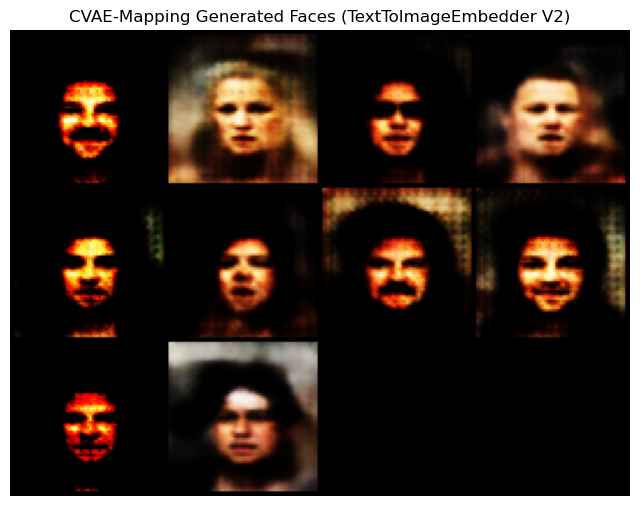

平均余弦相似度 (V2): 0.7287
Mapped Image Embeddings Tensor Shape: torch.Size([10, 512])
Actual Image Embeddings Tensor Shape: torch.Size([10, 512])


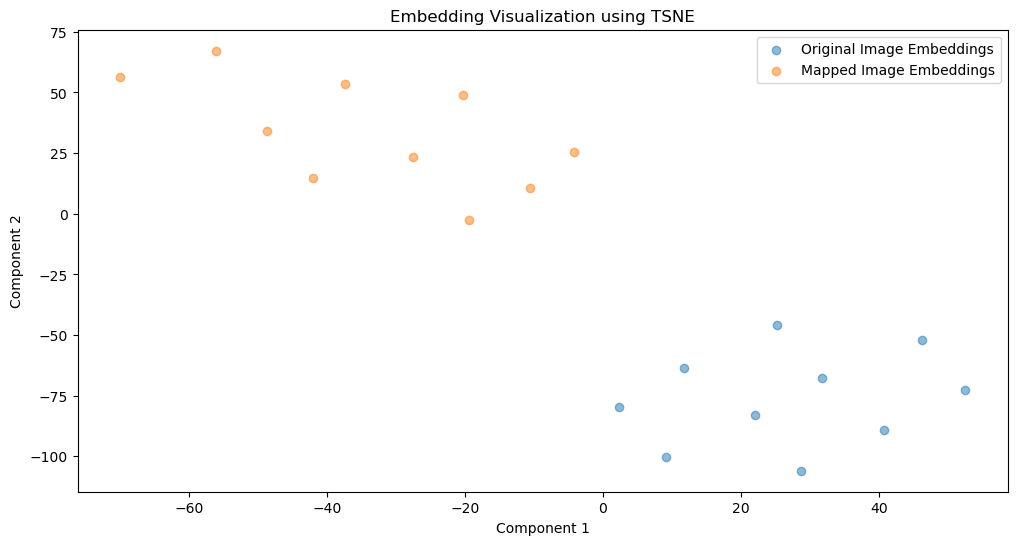

In [2]:
import os
import torch
import torch.nn as nn
import clip
from torchvision import transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

# ------------------------ #
# 1. 设备设置
# ------------------------ #

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# ------------------------ #
# 2. 加载CLIP模型
# ------------------------ #

clip_model, preprocess_clip = clip.load("ViT-B/32", device=device)
clip_model.eval()
print("CLIP模型已加载。")

# ------------------------ #
# 3. 定义ClipCVAE模型
# ------------------------ #

class ClipCVAE(nn.Module):
    def __init__(self, img_channels=3, img_size=64, latent_dim=128,
                 cond_dim=40, clip_dim=512):
        super(ClipCVAE, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.clip_dim = clip_dim

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels + cond_dim + clip_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(512*4*4, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, latent_dim)

        # 解码器
        self.decoder_input = nn.Linear(latent_dim + cond_dim + clip_dim, 512*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, c, clip_embedding):
        c = c.view(c.size(0), self.cond_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        clip_embedding = clip_embedding.view(clip_embedding.size(0), self.clip_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        x = torch.cat([x, c, clip_embedding], dim=1)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, clip_embedding):
        z = torch.cat([z, c, clip_embedding], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 512, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, c, clip_embedding):
        mu, logvar = self.encode(x, c, clip_embedding)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c, clip_embedding)
        return recon_x, mu, logvar

latent_dim = 128
cond_dim = 40
clip_dim = 512
cvae = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim,
               cond_dim=cond_dim, clip_dim=clip_dim).to(device)
cvae.load_state_dict(torch.load('clip_cvae_celeba.pth', map_location=device))
cvae = cvae.float()
cvae.eval()
print("ClipCVAE模型已加载并转换为 float32。")

# ------------------------ #
# 4. 定义TextToImageEmbedder模型 (V2 版本)
# ------------------------ #
# 请确保此结构与您训练text_to_image_embedder_v2.pth时使用的结构一致
# 定义优化后的映射网络模型 V2 (增加深度和宽度)
class TextToImageEmbedderV2(nn.Module): # V2 表示 Version 2
    def __init__(self, clip_dim=512, embed_dim=512):
        super(TextToImageEmbedderV2, self).__init__()
        self.mapping = nn.Sequential(
            nn.Linear(clip_dim, 4096), # 加宽到 4096
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(4096, 2048), # 加宽到 2048
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512), # 增加一个 512 维度的隐藏层
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, embed_dim) # 输出层保持不变
        )

    def forward(self, text_embeddings):
        image_embeddings = self.mapping(text_embeddings)
        return image_embeddings

embedder = TextToImageEmbedderV2(clip_dim=512, embed_dim=512).to(device) # 使用 TextToImageEmbedderV2 here!
embedder.load_state_dict(torch.load('text_to_image_embedder_v2.pth', map_location=device), strict=True) # 加载 v2 权重
embedder = embedder.float()
embedder.eval()
print("TextToImageEmbedder模型已加载并转换为 float32。")

# ------------------------ #
# 5. 定义属性标签映射函数 (与之前代码相同)
# ------------------------ #

def get_attributes_from_prompt(prompt):
    attrs = torch.zeros(40).float()
    attr_dict = {
        '5_o_Clock_Shadow': 1,
        'Arched_Eyebrows': 2,
        'Attractive': 3,
        'Bags_Under_Eyes': 4,
        'Bald': 5,
        'Bangs': 6,
        'Big_Lips': 7,
        'Big_Nose': 8,
        'Black_Hair': 9,
        'Blond_Hair': 10,
        'Blurry': 11,
        'Brown_Hair': 12,
        'Bushy_Eyebrows': 13,
        'Chubby': 14,
        'Double_Chin': 15,
        'Eyeglasses': 16,
        'Goatee': 17,
        'Gray_Hair': 18,
        'Heavy_Makeup': 19,
        'High_Cheekbones': 20,
        'Male': 21,
        'Mouth_Slightly_Open': 22,
        'Mustache': 23,
        'Narrow_Eyes': 24,
        'No_Beard': 25,
        'Oval_Face': 26,
        'Pale_Skin': 27,
        'Pointy_Nose': 28,
        'Receding_Hairline': 29,
        'Rosy_Cheeks': 30,
        'Sideburns': 31,
        'Smiling': 32,
        'Straight_Hair': 33,
        'Wavy_Hair': 34,
        'Wearing_Earrings': 35,
        'Wearing_Hat': 36,
        'Wearing_Lipstick': 37,
        'Wearing_Necklace': 38,
        'Wearing_Necktie': 39,
        'Young': 40
    }

    keyword_attr_map = {
        'shadow': '5_o_Clock_Shadow',
        'arched eyebrows': 'Arched_Eyebrows',
        'attractive': 'Attractive',
        'bags under eyes': 'Bags_Under_Eyes',
        'bald': 'Bald',
        'bangs': 'Bangs',
        'big lips': 'Big_Lips',
        'big nose': 'Big_Nose',
        'black hair': 'Black_Hair',
        'blond hair': 'Blond_Hair',
        'blurry': 'Blurry',
        'brown hair': 'Brown_Hair',
        'bushy eyebrows': 'Bushy_Eyebrows',
        'chubby': 'Chubby',
        'double chin': 'Double_Chin',
        'eyeglasses': 'Eyeglasses',
        'goatee': 'Goatee',
        'gray hair': 'Gray_Hair',
        'heavy makeup': 'Heavy_Makeup',
        'high cheekbones': 'High_Cheekbones',
        'male': 'Male',
        'mouth slightly open': 'Mouth_Slightly_Open',
        'mustache': 'Mustache',
        'narrow eyes': 'Narrow_Eyes',
        'no beard': 'No_Beard',
        'oval face': 'Oval_Face',
        'pale skin': 'Pale_Skin',
        'pointy nose': 'Pointy_Nose',
        'receding hairline': 'Receding_Hairline',
        'rosy cheeks': 'Rosy_Cheeks',
        'sideburns': 'Sideburns',
        'smiling': 'Smiling',
        'straight hair': 'Straight_Hair',
        'wavy hair': 'Wavy_Hair',
        'wearing earrings': 'Wearing_Earrings',
        'wearing hat': 'Wearing_Hat',
        'wearing lipstick': 'Wearing_Lipstick',
        'wearing_necklace': 'Wearing_Necklace',
        'wearing necktie': 'Wearing_Necktie',
        'young': 'Young'
    }

    prompt = prompt.lower()
    for keyword, attr in keyword_attr_map.items():
        if keyword in prompt:
            attr_index = attr_dict[attr]
            attrs[attr_index - 1] = 1
    return attrs

def compute_cosine_similarity(mapped_embeddings, actual_embeddings):
    cos = nn.CosineSimilarity(dim=1)
    similarity = cos(mapped_embeddings, actual_embeddings)
    return similarity.mean().item()

def visualize_embeddings(original_emb, mapped_emb, num_samples=1000, method='tsne'):
    original_emb = original_emb[:num_samples].cpu().numpy()
    mapped_emb = mapped_emb[:num_samples].cpu().numpy()

    if num_samples < 2:
        print("样本数量过少，使用 PCA 进行可视化。")
        method = 'pca'
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        # 修改处：显式设置 perplexity，使其小于 n_samples
        perplexity_value = min(30, num_samples - 1) # 或者设置为更小的值，如 5, 10
        if perplexity_value <= 0:
            perplexity_value = 1 # Ensure perplexity is at least 1
        reducer = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
    else:
        reducer = PCA(n_components=2)

    combined = np.vstack((original_emb, mapped_emb))
    reduced = reducer.fit_transform(combined)

    plt.figure(figsize=(12, 6))
    plt.scatter(reduced[:num_samples, 0], reduced[:num_samples, 1], label='Original Image Embeddings', alpha=0.5)
    plt.scatter(reduced[num_samples:, 0], reduced[num_samples:, 1], label='Mapped Image Embeddings', alpha=0.5)
    plt.legend()
    plt.title(f"Embedding Visualization using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

def generate_images_from_text(text_prompts, model_cvae, model_embedder, clip_model, device,
                             img_size=64, cond_dim=40, latent_dim=128, num_images=16):
    with torch.no_grad():
        text_tokens = clip.tokenize(text_prompts).to(device)
        text_embeddings = clip_model.encode_text(text_tokens).float()
        mapped_image_embeddings = model_embedder(text_embeddings)
        z = torch.randn(num_images, latent_dim).to(device)
        attrs = torch.stack([get_attributes_from_prompt(prompt) for prompt in text_prompts]).to(device)
        if len(text_prompts) != num_images:
            raise ValueError("文本描述的数量应与要生成的图像数量一致。")
        generated_imgs = model_cvae.decode(z, attrs, mapped_image_embeddings)
        return generated_imgs

def show_images(images, title="Generated Images", nrow=4):
    images = images * 0.5 + 0.5
    images = images.clamp(0, 1)
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    np_grid = grid.cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    # ------------------------ #
    # 6. 生成多张图片并计算相似度, TSNE
    # ------------------------ #
    text_prompts = [
        "smiling man",
        "young woman with blond hair",
        "man with glasses",
        "elderly woman with gray hair",
        "young man with black hair",
        "woman with heavy makeup",
        "man with mustache",
        "young woman smiling",
        "man with beard",
        "woman wearing hat"
    ]
    num_images = len(text_prompts)

    try:
        generated_images = generate_images_from_text(
            text_prompts, cvae, embedder, clip_model, device,
            img_size=64, cond_dim=40, latent_dim=latent_dim, num_images=num_images
        )
    except Exception as e:
        print(f"图像生成过程中出现错误: {e}")
        raise

    show_images(generated_images, title="CVAE-Mapping Generated Faces (TextToImageEmbedder V2)", nrow=4) # Updated title

    mapped_image_embeddings_list = []
    actual_image_embeddings_list = []
    similarities = []

    with torch.no_grad():
        for prompt in text_prompts:
            text_tokens = clip.tokenize([prompt]).to(device) # Tokenize each prompt individually
            text_embedding = clip_model.encode_text(text_tokens).float()
            mapped_image_embedding = embedder(text_embedding)
            mapped_image_embeddings_list.append(mapped_image_embedding)

        for i in range(num_images):
            image = generated_images[i].unsqueeze(0).cpu() # Get each generated image
            image = image * 0.5 + 0.5
            image = image.clamp(0, 1)
            pil_image = transforms.ToPILImage()(image[0])
            preprocessed_image = preprocess_clip(pil_image).unsqueeze(0).to(device)
            actual_image_embedding = clip_model.encode_image(preprocessed_image).float()
            actual_image_embeddings_list.append(actual_image_embedding)

            similarity = compute_cosine_similarity(mapped_image_embeddings_list[i], actual_image_embeddings_list[i]) # Calculate similarity for each pair
            similarities.append(similarity)

        avg_similarity = np.mean(similarities)
        print(f"平均余弦相似度 (V2): {avg_similarity:.4f}") # Updated print statement

        # Concatenate embeddings for TSNE visualization
        mapped_image_embeddings_tensor = torch.cat(mapped_image_embeddings_list, dim=0)
        actual_image_embeddings_tensor = torch.cat(actual_image_embeddings_list, dim=0)

        print("Mapped Image Embeddings Tensor Shape:", mapped_image_embeddings_tensor.shape)
        print("Actual Image Embeddings Tensor Shape:", actual_image_embeddings_tensor.shape)

    visualize_embeddings(actual_image_embeddings_tensor, mapped_image_embeddings_tensor, num_samples=num_images, method='tsne')

使用设备: cuda
CLIP模型已加载。
ClipCVAE模型已加载并转换为 float32。
TextToImageEmbedder模型已加载并转换为 float32。


/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26144 (\N{CJK UNIFIED IDEOGRAPH-6620}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23556 (\N{CJK UNIFIED IDEOGRAPH-5C04}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32593 (\N{CJK UNIFIED IDEOGRAPH-7F51}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32476 (\N{CJK UNIFIED IDEOGRAPH-7EDC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pyl

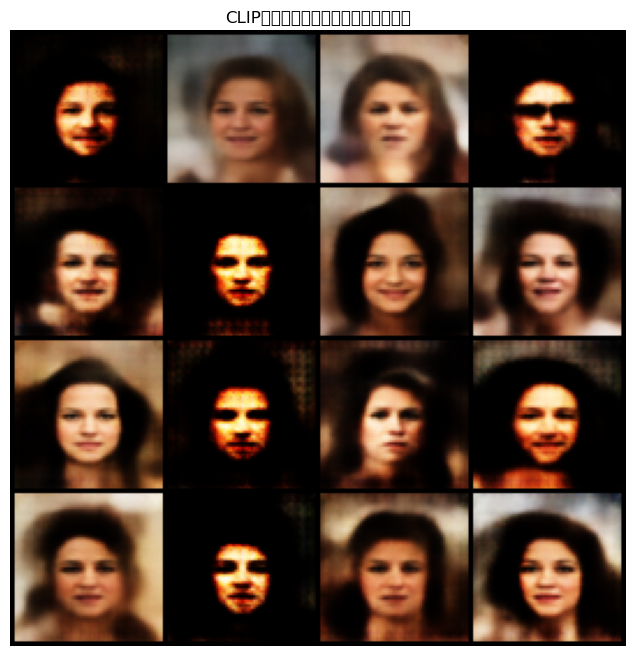

验证集映射嵌入与真实嵌入的平均余弦相似度: 0.8290


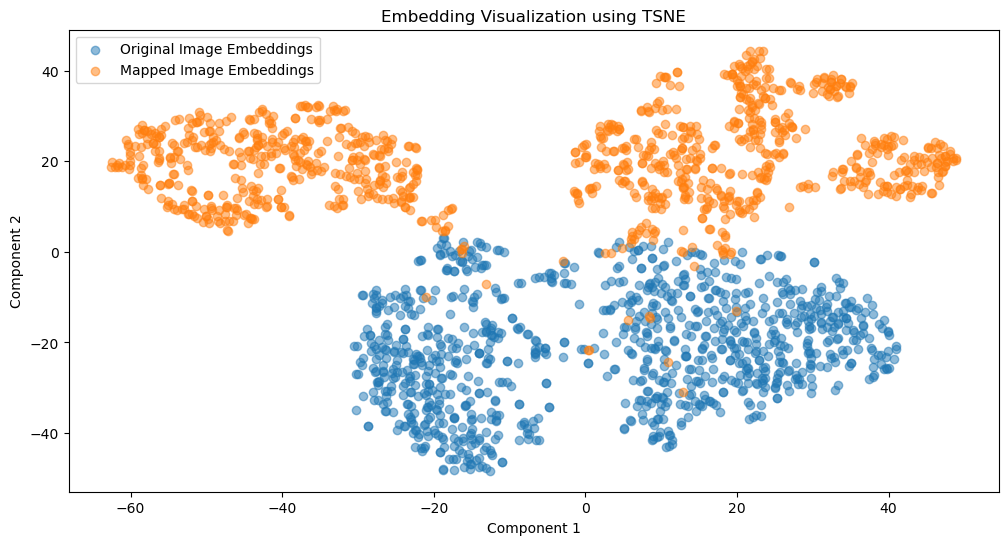

In [1]:
import os
import torch
import torch.nn as nn
import clip
from torchvision import transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
import numpy as np

# ------------------------ #
# 1. 设备设置
# ------------------------ #

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# ------------------------ #
# 2. 加载CLIP模型
# ------------------------ #

clip_model, preprocess_clip = clip.load("ViT-B/32", device=device)
clip_model.eval()
print("CLIP模型已加载。")

# ------------------------ #
# 3. 定义ClipCVAE模型
# ------------------------ #

class ClipCVAE(nn.Module):
    def __init__(self, img_channels=3, img_size=64, latent_dim=128, 
                 cond_dim=40, clip_dim=512):
        super(ClipCVAE, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.clip_dim = clip_dim

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels + cond_dim + clip_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(512*4*4, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, latent_dim)

        # 解码器
        self.decoder_input = nn.Linear(latent_dim + cond_dim + clip_dim, 512*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, c, clip_embedding):
        c = c.view(c.size(0), self.cond_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        clip_embedding = clip_embedding.view(clip_embedding.size(0), self.clip_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        x = torch.cat([x, c, clip_embedding], dim=1)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, clip_embedding):
        z = torch.cat([z, c, clip_embedding], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 512, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, c, clip_embedding):
        mu, logvar = self.encode(x, c, clip_embedding)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c, clip_embedding)
        return recon_x, mu, logvar

latent_dim = 128
cond_dim = 40
clip_dim = 512
cvae = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim, 
               cond_dim=cond_dim, clip_dim=clip_dim).to(device)
cvae.load_state_dict(torch.load('clip_cvae_celeba.pth', map_location=device))
cvae = cvae.float()
cvae.eval()
print("ClipCVAE模型已加载并转换为 float32。")

# ------------------------ #
# 4. 定义TextToImageEmbedder模型
# ------------------------ #
# 请确保此结构与您训练text_to_image_embedder.pth时使用的结构一致
# 定义优化后的映射网络模型
class TextToImageEmbedder(nn.Module):
    def __init__(self, clip_dim=512, embed_dim=512):
        super(TextToImageEmbedder, self).__init__()
        self.mapping = nn.Sequential(
            nn.Linear(clip_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, embed_dim),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
    
    def forward(self, text_embeddings):
        image_embeddings = self.mapping(text_embeddings)
        return image_embeddings

embedder = TextToImageEmbedder(clip_dim=512, embed_dim=512).to(device)
embedder.load_state_dict(torch.load('text_to_image_embedder.pth', map_location=device), strict=True)
embedder = embedder.float()
embedder.eval()
print("TextToImageEmbedder模型已加载并转换为 float32。")

# ------------------------ #
# 5. 定义属性标签映射函数
# ------------------------ #

def get_attributes_from_prompt(prompt):
    attrs = torch.zeros(40).float()
    attr_dict = {
        '5_o_Clock_Shadow': 1,
        'Arched_Eyebrows': 2,
        'Attractive': 3,
        'Bags_Under_Eyes': 4,
        'Bald': 5,
        'Bangs': 6,
        'Big_Lips': 7,
        'Big_Nose': 8,
        'Black_Hair': 9,
        'Blond_Hair': 10,
        'Blurry': 11,
        'Brown_Hair': 12,
        'Bushy_Eyebrows': 13,
        'Chubby': 14,
        'Double_Chin': 15,
        'Eyeglasses': 16,
        'Goatee': 17,
        'Gray_Hair': 18,
        'Heavy_Makeup': 19,
        'High_Cheekbones': 20,
        'Male': 21,
        'Mouth_Slightly_Open': 22,
        'Mustache': 23,
        'Narrow_Eyes': 24,
        'No_Beard': 25,
        'Oval_Face': 26,
        'Pale_Skin': 27,
        'Pointy_Nose': 28,
        'Receding_Hairline': 29,
        'Rosy_Cheeks': 30,
        'Sideburns': 31,
        'Smiling': 32,
        'Straight_Hair': 33,
        'Wavy_Hair': 34,
        'Wearing_Earrings': 35,
        'Wearing_Hat': 36,
        'Wearing_Lipstick': 37,
        'Wearing_Necklace': 38,
        'Wearing_Necktie': 39,
        'Young': 40
    }

    keyword_attr_map = {
        'shadow': '5_o_Clock_Shadow',
        'arched eyebrows': 'Arched_Eyebrows',
        'attractive': 'Attractive',
        'bags under eyes': 'Bags_Under_Eyes',
        'bald': 'Bald',
        'bangs': 'Bangs',
        'big lips': 'Big_Lips',
        'big nose': 'Big_Nose',
        'black hair': 'Black_Hair',
        'blond hair': 'Blond_Hair',
        'blurry': 'Blurry',
        'brown hair': 'Brown_Hair',
        'bushy eyebrows': 'Bushy_Eyebrows',
        'chubby': 'Chubby',
        'double chin': 'Double_Chin',
        'eyeglasses': 'Eyeglasses',
        'goatee': 'Goatee',
        'gray hair': 'Gray_Hair',
        'heavy makeup': 'Heavy_Makeup',
        'high cheekbones': 'High_Cheekbones',
        'male': 'Male',
        'mouth slightly open': 'Mouth_Slightly_Open',
        'mustache': 'Mustache',
        'narrow eyes': 'Narrow_Eyes',
        'no beard': 'No_Beard',
        'oval face': 'Oval_Face',
        'pale skin': 'Pale_Skin',
        'pointy nose': 'Pointy_Nose',
        'receding hairline': 'Receding_Hairline',
        'rosy cheeks': 'Rosy_Cheeks',
        'sideburns': 'Sideburns',
        'smiling': 'Smiling',
        'straight hair': 'Straight_Hair',
        'wavy hair': 'Wavy_Hair',
        'wearing earrings': 'Wearing_Earrings',
        'wearing hat': 'Wearing_Hat',
        'wearing lipstick': 'Wearing_Lipstick',
        'wearing necklace': 'Wearing_Necklace',
        'wearing necktie': 'Wearing_Necktie',
        'young': 'Young'
    }

    prompt = prompt.lower()
    for keyword, attr in keyword_attr_map.items():
        if keyword in prompt:
            attr_index = attr_dict[attr]
            attrs[attr_index - 1] = 1
    return attrs

def compute_cosine_similarity(mapped_embeddings, actual_embeddings):
    cos = nn.CosineSimilarity(dim=1)
    similarity = cos(mapped_embeddings, actual_embeddings)
    return similarity.mean().item()

def visualize_embeddings(original_emb, mapped_emb, num_samples=1000, method='tsne'):
    original_emb = original_emb[:num_samples].cpu().numpy()
    mapped_emb = mapped_emb[:num_samples].cpu().numpy()

    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=2)

    combined = np.vstack((original_emb, mapped_emb))
    reduced = reducer.fit_transform(combined)

    plt.figure(figsize=(12, 6))
    plt.scatter(reduced[:num_samples, 0], reduced[:num_samples, 1], label='Original Image Embeddings', alpha=0.5)
    plt.scatter(reduced[num_samples:, 0], reduced[num_samples:, 1], label='Mapped Image Embeddings', alpha=0.5)
    plt.legend()
    plt.title(f"Embedding Visualization using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

def generate_images_from_text(text_prompts, model_cvae, model_embedder, clip_model, device, 
                             img_size=64, cond_dim=40, latent_dim=128, num_images=16):
    with torch.no_grad():
        text_tokens = clip.tokenize(text_prompts).to(device)
        text_embeddings = clip_model.encode_text(text_tokens).float()
        mapped_image_embeddings = model_embedder(text_embeddings)
        z = torch.randn(num_images, latent_dim).to(device)
        attrs = torch.stack([get_attributes_from_prompt(prompt) for prompt in text_prompts]).to(device)
        if len(text_prompts) != num_images:
            raise ValueError("文本描述的数量应与要生成的图像数量一致。")
        generated_imgs = model_cvae.decode(z, attrs, mapped_image_embeddings)
        return generated_imgs

def show_images(images, title="Generated Images", nrow=4):
    images = images * 0.5 + 0.5
    images = images.clamp(0, 1)
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    np_grid = grid.cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    text_prompts = [
        "A portrait of a young woman with a smile",
        "A realistic face with a smile",
        "A person with distinct facial features",
        "A portrait of a middle-aged man with glasses",
        "A happy elderly woman",
        "A young man with a beard",
        "A smiling person with dark hair",
        "A person with blue eyes and a pleasant expression",
        "A cheerful young woman with long hair",
        "A man with a serious look",
        "A woman with a stylish haircut",
        "A person with a friendly smile",
        "A portrait of a person with freckles",
        "A young person with bright eyes",
        "A person with a confident expression",
        "A portrait of a person with curly hair"
    ]

    num_images = len(text_prompts)

    try:
        generated_images = generate_images_from_text(
            text_prompts, cvae, embedder, clip_model, device, 
            img_size=64, cond_dim=40, latent_dim=128, num_images=num_images
        )
    except Exception as e:
        print(f"图像生成过程中出现错误: {e}")
        raise

    show_images(generated_images, title="CLIP映射网络引导的条件生成人脸图像", nrow=4)

    VALIDATION_TEXT_EMBEDDINGS_PATH = '/root/autodl-tmp/clip_embeddings/text_embeddings_partition_1.pt'
    VALIDATION_IMAGE_EMBEDDINGS_PATH = '/root/autodl-tmp/clip_embeddings/image_embeddings_partition_1.pt'

    try:
        validation_text_embeddings = torch.load(VALIDATION_TEXT_EMBEDDINGS_PATH)
        validation_image_embeddings = torch.load(VALIDATION_IMAGE_EMBEDDINGS_PATH)
    except Exception as e:
        print(f"Error loading validation embeddings: {e}")
        raise

    assert len(validation_text_embeddings) == len(validation_image_embeddings), "验证集文本和图像嵌入的数量不匹配"

    validation_text_embeddings = validation_text_embeddings.to(device).float()
    validation_image_embeddings = validation_image_embeddings.to(device).float()

    with torch.no_grad():
        mapped_validation_image_embeddings = embedder(validation_text_embeddings)

    similarity = compute_cosine_similarity(mapped_validation_image_embeddings, validation_image_embeddings)
    print(f"验证集映射嵌入与真实嵌入的平均余弦相似度: {similarity:.4f}")

    visualize_embeddings(validation_image_embeddings, mapped_validation_image_embeddings, num_samples=1000, method='tsne')


使用设备: cuda
CLIP模型已加载。
ClipCVAE模型已加载并转换为 float32。
TextToImageEmbedder模型已加载并转换为 float32。


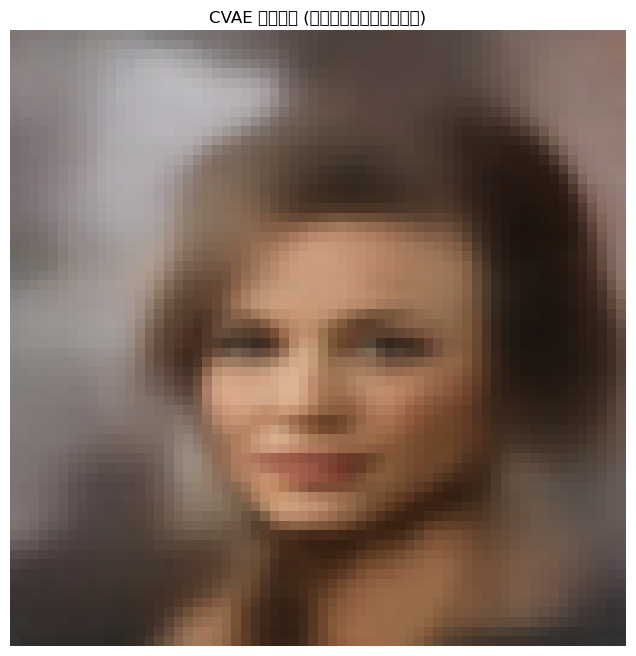

生成图像的嵌入与原始验证集嵌入的余弦相似度: 0.6877


In [19]:
import os
import torch
import torch.nn as nn
import clip
from torchvision import transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np

# ------------------------ #
# 1. 设备设置
# ------------------------ #

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# ------------------------ #
# 2. 加载CLIP模型
# ------------------------ #

clip_model, preprocess_clip = clip.load("ViT-B/32", device=device)
clip_model.eval()
print("CLIP模型已加载。")

# ------------------------ #
# 3. 定义ClipCVAE模型
# ------------------------ #

class ClipCVAE(nn.Module):
    def __init__(self, img_channels=3, img_size=64, latent_dim=128,
                 cond_dim=40, clip_dim=512):
        super(ClipCVAE, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.clip_dim = clip_dim

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels + cond_dim + clip_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(512*4*4, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, latent_dim)

        # 解码器
        self.decoder_input = nn.Linear(latent_dim + cond_dim + clip_dim, 512*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, c, clip_embedding):
        c = c.view(c.size(0), self.cond_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        clip_embedding = clip_embedding.view(clip_embedding.size(0), self.clip_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        x = torch.cat([x, c, clip_embedding], dim=1)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, clip_embedding):
        z = torch.cat([z, c, clip_embedding], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 512, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, c, clip_embedding):
        mu, logvar = self.encode(x, c, clip_embedding)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c, clip_embedding)
        return recon_x, mu, logvar

latent_dim = 128
cond_dim = 40
clip_dim = 512
cvae = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim,
               cond_dim=cond_dim, clip_dim=clip_dim).to(device)
cvae.load_state_dict(torch.load('clip_cvae_celeba.pth', map_location=device))
cvae = cvae.float()
cvae.eval()
print("ClipCVAE模型已加载并转换为 float32。")

# ------------------------ #
# 4. 定义TextToImageEmbedder模型 (Original V1)
# ------------------------ #
# 请确保此结构与您训练text_to_image_embedder.pth时使用的结构一致
# 定义优化后的映射网络模型
class TextToImageEmbedder(nn.Module):
    def __init__(self, clip_dim=512, embed_dim=512):
        super(TextToImageEmbedder, self).__init__()
        self.mapping = nn.Sequential(
            nn.Linear(clip_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, embed_dim),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, text_embeddings):
        image_embeddings = self.mapping(text_embeddings)
        return image_embeddings

embedder = TextToImageEmbedder(clip_dim=512, embed_dim=512).to(device) # Use original TextToImageEmbedder (V1)
embedder.load_state_dict(torch.load('text_to_image_embedder.pth', map_location=device), strict=True) # Load V1 weights
embedder = embedder.float()
embedder.eval()
print("TextToImageEmbedder模型已加载并转换为 float32。")

# ------------------------ #
# 5. 定义属性标签映射函数 (与之前代码相同)
# ------------------------ #

def get_attributes_from_prompt(prompt):
    attrs = torch.zeros(40).float()
    attr_dict = {
        '5_o_Clock_Shadow': 1,
        'Arched_Eyebrows': 2,
        'Attractive': 3,
        'Bags_Under_Eyes': 4,
        'Bald': 5,
        'Bangs': 6,
        'Big_Lips': 7,
        'Big_Nose': 8,
        'Black_Hair': 9,
        'Blond_Hair': 10,
        'Blurry': 11,
        'Brown_Hair': 12,
        'Bushy_Eyebrows': 13,
        'Chubby': 14,
        'Double_Chin': 15,
        'Eyeglasses': 16,
        'Goatee': 17,
        'Gray_Hair': 18,
        'Heavy_Makeup': 19,
        'High_Cheekbones': 20,
        'Male': 21,
        'Mouth_Slightly_Open': 22,
        'Mustache': 23,
        'Narrow_Eyes': 24,
        'No_Beard': 25,
        'Oval_Face': 26,
        'Pale_Skin': 27,
        'Pointy_Nose': 28,
        'Receding_Hairline': 29,
        'Rosy_Cheeks': 30,
        'Sideburns': 31,
        'Smiling': 32,
        'Straight_Hair': 33,
        'Wavy_Hair': 34,
        'Wearing_Earrings': 35,
        'Wearing_Hat': 36,
        'Wearing_Lipstick': 37,
        'Wearing_Necklace': 38,
        'Wearing_Necktie': 39,
        'Young': 40
    }

    keyword_attr_map = {
        'shadow': '5_o_Clock_Shadow',
        'arched eyebrows': 'Arched_Eyebrows',
        'attractive': 'Attractive',
        'bags under eyes': 'Bags_Under_Eyes',
        'bald': 'Bald',
        'bangs': 'Bangs',
        'big lips': 'Big_Lips',
        'big nose': 'Big_Nose',
        'black hair': 'Black_Hair',
        'blond hair': 'Blond_Hair',
        'blurry': 'Blurry',
        'brown hair': 'Brown_Hair',
        'bushy eyebrows': 'Bushy_Eyebrows',
        'chubby': 'Chubby',
        'double chin': 'Double_Chin',
        'eyeglasses': 'Eyeglasses',
        'goatee': 'Goatee',
        'gray hair': 'Gray_Hair',
        'heavy makeup': 'Heavy_Makeup',
        'high cheekbones': 'High_Cheekbones',
        'male': 'Male',
        'mouth slightly open': 'Mouth_Slightly_Open',
        'mustache': 'Mustache',
        'narrow eyes': 'Narrow_Eyes',
        'no beard': 'No_Beard',
        'oval face': 'Oval_Face',
        'pale skin': 'Pale_Skin',
        'pointy nose': 'Pointy_Nose',
        'receding hairline': 'Receding_Hairline',
        'rosy cheeks': 'Rosy_Cheeks',
        'sideburns': 'Sideburns',
        'smiling': 'Smiling',
        'straight hair': 'Straight_Hair',
        'wavy hair': 'Wavy_Hair',
        'wearing earrings': 'Wearing_Earrings',
        'wearing hat': 'Wearing_Hat',
        'wearing lipstick': 'Wearing_Lipstick',
        'wearing_necklace': 'Wearing_Necklace',
        'wearing necktie': 'Wearing_Necktie',
        'young': 'Young'
    }

    prompt = prompt.lower()
    for keyword, attr in keyword_attr_map.items():
        if keyword in prompt:
            attr_index = attr_dict[attr]
            attrs[attr_index - 1] = 1
    return attrs

def compute_cosine_similarity(mapped_embeddings, actual_embeddings):
    cos = nn.CosineSimilarity(dim=1)
    similarity = cos(mapped_embeddings, actual_embeddings)
    return similarity.mean().item()

def visualize_embeddings(original_emb, mapped_emb, num_samples=1000, method='tsne'):
    original_emb = original_emb[:num_samples].cpu().numpy()
    mapped_emb = mapped_emb[:num_samples].cpu().numpy()

    if num_samples < 2:
        print("样本数量过少，使用 PCA 进行可视化。")
        method = 'pca'
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        # 修改处：显式设置 perplexity，使其小于 n_samples
        perplexity_value = min(30, num_samples - 1) # 或者设置为更小的值，如 5, 10
        if perplexity_value <= 0:
            perplexity_value = 1 # Ensure perplexity is at least 1
        reducer = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
    else:
        reducer = PCA(n_components=2)

    combined = np.vstack((original_emb, mapped_emb))
    reduced = reducer.fit_transform(combined)

    plt.figure(figsize=(12, 6))
    plt.scatter(reduced[:num_samples, 0], reduced[:num_samples, 1], label='Original Image Embeddings', alpha=0.5)
    plt.scatter(reduced[num_samples:, 0], reduced[num_samples:, 1], label='Mapped Image Embeddings', alpha=0.5)
    plt.legend()
    plt.title(f"Embedding Visualization using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

def generate_images_from_text(text_prompts, model_cvae, model_embedder, clip_model, device,
                             img_size=64, cond_dim=40, latent_dim=128, num_images=16):
    with torch.no_grad():
        text_tokens = clip.tokenize(text_prompts).to(device)
        text_embeddings = clip_model.encode_text(text_tokens).float()
        mapped_image_embeddings = model_embedder(text_embeddings)
        z = torch.randn(num_images, latent_dim).to(device)
        attrs = torch.stack([get_attributes_from_prompt(prompt) for prompt in text_prompts]).to(device)
        if len(text_prompts) != num_images:
            raise ValueError("文本描述的数量应与要生成的图像数量一致。")
        generated_imgs = model_cvae.decode(z, attrs, mapped_image_embeddings)
        return generated_imgs

def show_images(images, title="Generated Images", nrow=4):
    images = images * 0.5 + 0.5
    images = images.clamp(0, 1)
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    np_grid = grid.cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

def generate_image_from_image_embedding(image_embedding, model_cvae, device, cond_dim=40, latent_dim=128):
    """
    直接使用图像嵌入生成单张图片，绕过文本映射网络。
    """
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device) # 1张图片的 z 向量
        attrs = torch.zeros(1, cond_dim).to(device).float() # 假设属性为零向量，可以根据需要修改
        generated_img = model_cvae.decode(z, attrs, image_embedding) # 直接使用 image_embedding
        return generated_img

if __name__ == "__main__":
    # ------------------------ #
    # 6. 生成单张图片，使用 验证集图像嵌入
    # ------------------------ #
    VALIDATION_IMAGE_EMBEDDINGS_PATH = '/root/autodl-tmp/clip_embeddings/image_embeddings_partition_1.pt'

    try:
        validation_image_embeddings = torch.load(VALIDATION_IMAGE_EMBEDDINGS_PATH)
    except Exception as e:
        print(f"Error loading validation image embeddings: {e}")
        raise

    validation_image_embeddings = validation_image_embeddings.to(device).float()

    # 随机选择一个验证集图像嵌入 (例如，第一个)
    selected_image_embedding = validation_image_embeddings[0].unsqueeze(0) # 获取第一个嵌入并添加 batch 维度

    try:
        generated_image_direct = generate_image_from_image_embedding(
            selected_image_embedding, cvae, device
        )
    except Exception as e:
        print(f"图像生成过程中出现错误: {e}")
        raise

    show_images(generated_image_direct, title="CVAE 生成图像 (直接使用验证集图像嵌入)", nrow=1) # 修改标题

    # (可选) 计算生成图像与所用嵌入的相似度
    with torch.no_grad():
        image = generated_image_direct.cpu()
        image = image * 0.5 + 0.5
        image = image.clamp(0, 1)
        pil_image = transforms.ToPILImage()(image[0])
        preprocessed_image = preprocess_clip(pil_image).unsqueeze(0).to(device)
        actual_image_embedding = clip_model.encode_image(preprocessed_image).float()

        similarity = compute_cosine_similarity(selected_image_embedding, actual_image_embedding)
        print(f"生成图像的嵌入与原始验证集嵌入的余弦相似度: {similarity:.4f}") # 打印相似度

In [ ]:
import os
import torch
import torch.nn as nn
import clip
from torchvision import transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

# ------------------------ #
# 1. 设备设置
# ------------------------ #

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# ------------------------ #
# 2. 加载CLIP模型
# ------------------------ #

clip_model, preprocess_clip = clip.load("ViT-B/32", device=device)
clip_model.eval()
print("CLIP模型已加载。")

# ------------------------ #
# 3. 定义ClipCVAE模型
# ------------------------ #

class ClipCVAE(nn.Module):
    def __init__(self, img_channels=3, img_size=64, latent_dim=128,
                 cond_dim=40, clip_dim=512):
        super(ClipCVAE, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.clip_dim = clip_dim

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels + cond_dim + clip_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(512*4*4, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, latent_dim)

        # 解码器
        self.decoder_input = nn.Linear(latent_dim + cond_dim + clip_dim, 512*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, c, clip_embedding):
        c = c.view(c.size(0), self.cond_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        clip_embedding = clip_embedding.view(clip_embedding.size(0), self.clip_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        x = torch.cat([x, c, clip_embedding], dim=1)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, clip_embedding):
        z = torch.cat([z, c, clip_embedding], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 512, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, c, clip_embedding):
        mu, logvar = self.encode(x, c, clip_embedding)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c, clip_embedding)
        return recon_x, mu, logvar

latent_dim = 128
cond_dim = 40
clip_dim = 512
cvae = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim,
               cond_dim=cond_dim, clip_dim=clip_dim).to(device)
cvae.load_state_dict(torch.load('clip_cvae_celeba.pth', map_location=device))
cvae = cvae.float()
cvae.eval()
print("ClipCVAE模型已加载并转换为 float32。")

# ------------------------ #
# 4. 定义TextToImageEmbedder模型 (All Versions)
# ------------------------ #
# 定义优化后的映射网络模型 (Original V1)
class TextToImageEmbedder(nn.Module):
    def __init__(self, clip_dim=512, embed_dim=512):
        super(TextToImageEmbedder, self).__init__()
        self.mapping = nn.Sequential(
            nn.Linear(clip_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, embed_dim),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, text_embeddings):
        image_embeddings = self.mapping(text_embeddings)
        return image_embeddings

# 定义优化后的映射网络模型 V2 (增加深度和宽度)
class TextToImageEmbedderV2(nn.Module): # V2 表示 Version 2
    def __init__(self, clip_dim=512, embed_dim=512):
        super(TextToImageEmbedderV2, self).__init__()
        self.mapping = nn.Sequential(
            nn.Linear(clip_dim, 4096), # 加宽到 4096
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(4096, 2048), # 加宽到 2048
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512), # 增加一个 512 维度的隐藏层
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, embed_dim) # 输出层保持不变
        )

    def forward(self, text_embeddings):
        image_embeddings = self.mapping(text_embeddings)
        return image_embeddings

# ------------------------ #
# 5. 定义属性标签映射函数 (与之前代码相同)
# ------------------------ #

def get_attributes_from_prompt(prompt):
    attrs = torch.zeros(40).float()
    attr_dict = {
        '5_o_Clock_Shadow': 1,
        'Arched_Eyebrows': 2,
        'Attractive': 3,
        'Bags_Under_Eyes': 4,
        'Bald': 5,
        'Bangs': 6,
        'Big_Lips': 7,
        'Big_Nose': 8,
        'Black_Hair': 9,
        'Blond_Hair': 10,
        'Blurry': 11,
        'Brown_Hair': 12,
        'Bushy_Eyebrows': 13,
        'Chubby': 14,
        'Double_Chin': 15,
        'Eyeglasses': 16,
        'Goatee': 17,
        'Gray_Hair': 18,
        'Heavy_Makeup': 19,
        'High_Cheekbones': 20,
        'Male': 21,
        'Mouth_Slightly_Open': 22,
        'Mustache': 23,
        'Narrow_Eyes': 24,
        'No_Beard': 25,
        'Oval_Face': 26,
        'Pale_Skin': 27,
        'Pointy_Nose': 28,
        'Receding_Hairline': 29,
        'Rosy_Cheeks': 30,
        'Sideburns': 31,
        'Smiling': 32,
        'Straight_Hair': 33,
        'Wavy_Hair': 34,
        'Wearing_Earrings': 35,
        'Wearing_Hat': 36,
        'Wearing_Lipstick': 37,
        'Wearing_Necklace': 38,
        'Wearing_Necktie': 39,
        'Young': 40
    }

    keyword_attr_map = {
        'shadow': '5_o_Clock_Shadow',
        'arched eyebrows': 'Arched_Eyebrows',
        'attractive': 'Attractive',
        'bags under eyes': 'Bags_Under_Eyes',
        'bald': 'Bald',
        'bangs': 'Bangs',
        'big lips': 'Big_Lips',
        'big nose': 'Big_Nose',
        'black hair': 'Black_Hair',
        'blond hair': 'Blond_Hair',
        'blurry': 'Blurry',
        'brown hair': 'Brown_Hair',
        'bushy eyebrows': 'Bushy_Eyebrows',
        'chubby': 'Chubby',
        'double chin': 'Double_Chin',
        'eyeglasses': 'Eyeglasses',
        'goatee': 'Goatee',
        'gray hair': 'Gray_Hair',
        'heavy makeup': 'Heavy_Makeup',
        'high cheekbones': 'High_Cheekbones',
        'male': 'Male',
        'mouth slightly open': 'Mouth_Slightly_Open',
        'mustache': 'Mustache',
        'narrow eyes': 'Narrow_Eyes',
        'no beard': 'No_Beard',
        'oval face': 'Oval_Face',
        'pale skin': 'Pale_Skin',
        'pointy nose': 'Pointy_Nose',
        'receding hairline': 'Receding_Hairline',
        'rosy cheeks': 'Rosy_Cheeks',
        'sideburns': 'Sideburns',
        'smiling': 'Smiling',
        'straight hair': 'Straight_Hair',
        'wavy hair': 'Wavy_Hair',
        'wearing earrings': 'Wearing_Earrings',
        'wearing hat': 'Wearing_Hat',
        'wearing lipstick': 'Wearing_Lipstick',
        'wearing_necklace': 'Wearing_Necklace',
        'wearing necktie': 'Wearing_Necktie',
        'young': 'Young'
    }

    prompt = prompt.lower()
    for keyword, attr in keyword_attr_map.items():
        if keyword in prompt:
            attr_index = attr_dict[attr]
            attrs[attr_index - 1] = 1
    return attrs

def compute_cosine_similarity(mapped_embeddings, actual_embeddings):
    cos = nn.CosineSimilarity(dim=1)
    similarity = cos(mapped_embeddings, actual_embeddings)
    return similarity.mean().item()

def visualize_embeddings(original_emb, mapped_emb, num_samples=1000, method='tsne'):
    original_emb = original_emb[:num_samples].cpu().numpy()
    mapped_emb = mapped_emb[:num_samples].cpu().numpy()

    if num_samples < 2:
        print("样本数量过少，使用 PCA 进行可视化。")
        method = 'pca'
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        # 修改处：显式设置 perplexity，使其小于 n_samples
        perplexity_value = min(30, num_samples - 1) # 或者设置为更小的值，如 5, 10
        if perplexity_value <= 0:
            perplexity_value = 1 # Ensure perplexity is at least 1
        reducer = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
    else:
        reducer = PCA(n_components=2)

    combined = np.vstack((original_emb, mapped_emb))
    reduced = reducer.fit_transform(combined)

    plt.figure(figsize=(12, 6))
    plt.scatter(reduced[:num_samples, 0], reduced[:num_samples, 1], label='Original Image Embeddings', alpha=0.5)
    plt.scatter(reduced[num_samples:, 0], reduced[num_samples:, 1], label='Mapped Image Embeddings', alpha=0.5)
    plt.legend()
    plt.title(f"Embedding Visualization using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

def generate_images_from_text(text_prompts, model_cvae, model_embedder, clip_model, device,
                             img_size=64, cond_dim=40, latent_dim=128, num_images=16):
    with torch.no_grad():
        text_tokens = clip.tokenize(text_prompts).to(device)
        text_embeddings = clip_model.encode_text(text_tokens).float()
        mapped_image_embeddings = model_embedder(text_embeddings)
        z = torch.randn(num_images, latent_dim).to(device)
        attrs = torch.stack([get_attributes_from_prompt(prompt) for prompt in text_prompts]).to(device)
        if len(text_prompts) != num_images:
            raise ValueError("文本描述的数量应与要生成的图像数量一致。")
        generated_imgs = model_cvae.decode(z, attrs, mapped_image_embeddings)
        return generated_imgs

def show_images(images, title="Generated Images", nrow=4, save_path=None): # Added save_path
    images = images * 0.5 + 0.5
    images = images.clamp(0, 1)
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    np_grid = grid.cpu().numpy()

    plt.figure(figsize=(12, 12)) # Adjusted figsize for better PDF quality
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    # plt.title(title)  # Removed title setting - THIS LINE IS COMMENTED OUT
    plt.axis('off')

    if save_path: # Save to PDF if save_path is provided
        plt.savefig(save_path, format='pdf', bbox_inches='tight', pad_inches=0.1) # savefig instead of show
        print(f"图像已保存到: {save_path}")
    else:
        plt.show() # Only show if no save path is given
    plt.close() # Close the plot to free memory


if __name__ == "__main__":
    # ------------------------ #
    # 6. 生成 16 张 "wearing glasses" 图像并保存为PDF - 所有Embedder版本 (No Titles)
    # ------------------------ #
    text_prompts_glasses = ["young woman with bangs and blond hair"] * 16  # 16 张 "wearing glasses"
    model_weights_paths = [
        ("text_to_image_embedder.pth", TextToImageEmbedder, "Original_V1"),
        ("text_to_image_embedder_v2.pth", TextToImageEmbedderV2, "V2"),
        ("text_to_image_embedder_v3.pth", TextToImageEmbedderV2, "V3") # V3 uses V2 architecture
    ]

    for model_path, model_class, model_version_name in model_weights_paths:
        output_pdf_path = f"wearing_glasses_images_no_title_{model_version_name}.pdf" # Dynamic PDF save path

        # 加载对应的 TextToImageEmbedder 模型和权重
        embedder = model_class(clip_dim=512, embed_dim=512).to(device)
        embedder.load_state_dict(torch.load(model_path, map_location=device), strict=True)
        embedder = embedder.float()
        embedder.eval()
        print(f"TextToImageEmbedder模型 ({model_version_name}) 已加载并转换为 float32。")


        try:
            generated_images_glasses = generate_images_from_text(
                text_prompts_glasses, cvae, embedder, clip_model, device,
                img_size=64, cond_dim=40, latent_dim=latent_dim, num_images=len(text_prompts_glasses)
            )
            print(f"CVAE-Mapping 图像生成成功 (wearing glasses) - {model_version_name}。")
        except Exception as e:
            print(f"CVAE-Mapping 图像生成过程中出现错误 (wearing glasses) - {model_version_name}: {e}")
            raise

        show_images(generated_images_glasses, nrow=4, save_path=output_pdf_path) # Removed title argument - THIS LINE IS MODIFIED
        print(f"Images saved to PDF: {output_pdf_path}")
        print("------------------------------------\n")

    print("所有模型的 Wearing Glasses 图像生成完成！")

使用设备: cuda
CLIP模型已加载。
ClipCVAE模型已加载并转换为 float32。
TextToImageEmbedder模型 (Original_V1) 已加载并转换为 float32。
CVAE-Mapping 图像生成成功 (wearing glasses) - Original_V1。
图像已保存到: wearing_glasses_images_no_title_Original_V1.pdf
Images saved to PDF: wearing_glasses_images_no_title_Original_V1.pdf
------------------------------------

TextToImageEmbedder模型 (V2) 已加载并转换为 float32。
CVAE-Mapping 图像生成成功 (wearing glasses) - V2。
图像已保存到: wearing_glasses_images_no_title_V2.pdf
Images saved to PDF: wearing_glasses_images_no_title_V2.pdf
------------------------------------

TextToImageEmbedder模型 (V3) 已加载并转换为 float32。
CVAE-Mapping 图像生成成功 (wearing glasses) - V3。
图像已保存到: wearing_glasses_images_no_title_V3.pdf
Images saved to PDF: wearing_glasses_images_no_title_V3.pdf
------------------------------------

所有模型的 Wearing Glasses 图像生成完成！
